### Chapter 8: Nonlinear Auto-regressive Network with Exogenous Inputs

A NARX is a type of recurrent dynamic neural network.

They have been used for
modeling nonlinear dynamic systems such as heat exchangers,
waste water treatment plants and petroleum refinery catalytic
reforming systems, movement in biological systems, and even
to predict solar radiation.

In this chapter, we illustrate the construction of a NARX
model to predict the United Kingdom annual Unemployment
rate.

Our goal is **to create a model that predicts the actual
level to within a comfort interval of 2 standard deviations of
the model prediction.**


The inputs are fed into delay units, which act as memory
of previous inputs. The output of the network is also stored in
delay units, which are fed directly into the hidden units.

In traditional time series modeling the nonlinear autoregressive
exogenous model is defined by the nonlinear mapping
function $f(.)$.
The nonlinear mapping $f(·)$ is generally unknown and needs
to be approximated. The approximation can be carried in many
ways; **when it is approximated by a multilayer perceptron**, the
resulting neural network is called **nonlinear auto-regressive network
with exogenous inputs** neural network.

They can remember the output
**over longer time steps than a Jordan or Elman neural network**.

In [102]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import preprocessing 

from pyneurgen.neuralnet import NeuralNet
from pyneurgen.recurrent import NARXRecurrent

In [103]:
excel_file =  pd.ExcelFile("UK_Economic.xls")
print(excel_file.sheet_names)

['Disclaimer', 'Front page', "What's new in V2.3", 'A1. Headline series', 'A2. Real GDP(A)', 'A3. Nominal GDP (A)', 'A4. Population, GDP per capita', 'A5. GNP and National Saving', 'A6. GDP(E) components - values', 'A7. GDP(E) components - volumes', 'A8. GDP(E) contributions', 'A9. Real GDP(O) components', 'A10. Factor incomes ', 'A11. Industry GVA shares', 'A12. GDP(I) components', "A13. Bank of England B'Sheet", 'A14. Monetary aggregates', 'A15. Credit aggregates', 'A16. Public Sector Borrowing', 'A17. Central govt borrowing ', 'A18. The National Debt', 'A19. Interest rates & asset ps ', 'A20. Property prices & rent', 'A21. Exchange rate data', 'A22. Off. trade values 1697-', 'A23. Trade volumes and prices', 'A24. Trade values and BOP', 'A25. Household saving', 'A26. Wages and prices', 'A27. GB Employment in C18th', 'A28. Employment & unemployment', 'A29. Public Sector Employment', 'A30. Employment by industry', 'A31. Hours worked', 'A32.Non-dwellings Capital Stock', 'A33. Productivi

The data we need is contained in the “**A1. Headline series**” worksheet.

In [104]:
spreadsheet = excel_file.parse('A1. Headline series')
print('First year is: ', spreadsheet.iloc[201,0])
print('Last year is: ', spreadsheet.iloc[361,0])

First year is:  1855
Last year is:  2015


In [105]:
len(spreadsheet.iloc[:,0])

362

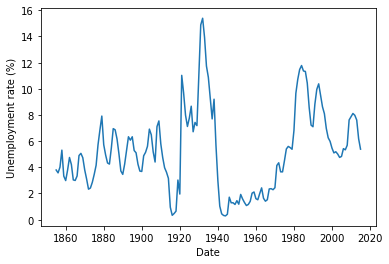

In [106]:
#unemployment = spreadsheet.iloc[6:,15]
#date = spreadsheet.iloc[6:,0]

unemployment = spreadsheet.iloc[201:362,15]
date = spreadsheet.iloc[201:,0]

plt.xlabel('Date')
plt.ylabel('Unemployment rate (%)')
plt.plot(date, unemployment)
plt.show()

### Working with the Attributes
The attribute set consists of four macroeconomic variables:

- 1. The consumer price inflation rate;
- 2. the central bank rank;
- 3. National debt as percentage of nominal Gross Domestic Product;
- 4. and the deviation of economic growth (GDP) from trend.

We are interested in **predicting the unemployment rate next
year**, given the value of each of the attributes this year. We
can do this by selecting our attribute data to match each year’s
unemployment rate with last year’s value of the attributes. In
other words by **lagging the attributes by time step (in this case
year)**.

In [107]:
inflation = spreadsheet.iloc[200:361 ,28]
bank_rate = spreadsheet.iloc[200:361 ,30]
debt = spreadsheet.iloc[200:361 ,57]
GDP_trend = spreadsheet.iloc[200:361 ,3]

<Figure size 432x288 with 0 Axes>

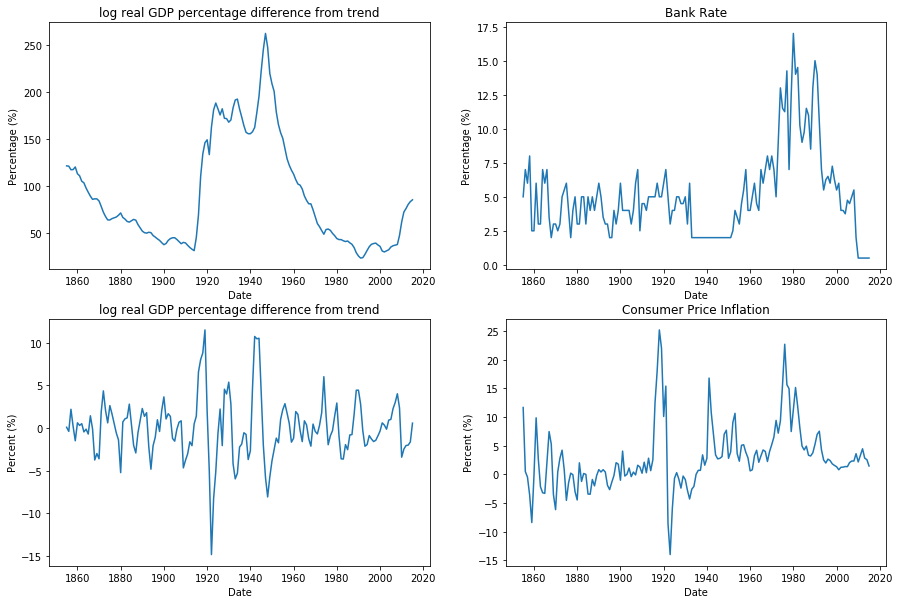

In [108]:
fig = plt.figure()

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.title('log real GDP percentage difference from trend')
plt.plot(date, debt )

plt.subplot(2, 2, 2)
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.title('Bank Rate')
plt.plot(date, bank_rate)

plt.subplot(2, 2, 3)
plt.xlabel('Date')
plt.ylabel('Percent (%)')
plt.title('log real GDP percentage difference from trend')
plt.plot(date, GDP_trend)


plt.subplot(2, 2, 4)
plt.xlabel('Date')
plt.ylabel('Percent (%)')
plt.title('Consumer Price Inflation')
plt.plot(date, inflation)

plt.show()

The relationship between the annual unemployment rate and each of these variables
is quite complex. 

It shows the scatter plot of each attribute against the unemployment rate.

The relationships appear to be highly non-linear.

<Figure size 432x288 with 0 Axes>

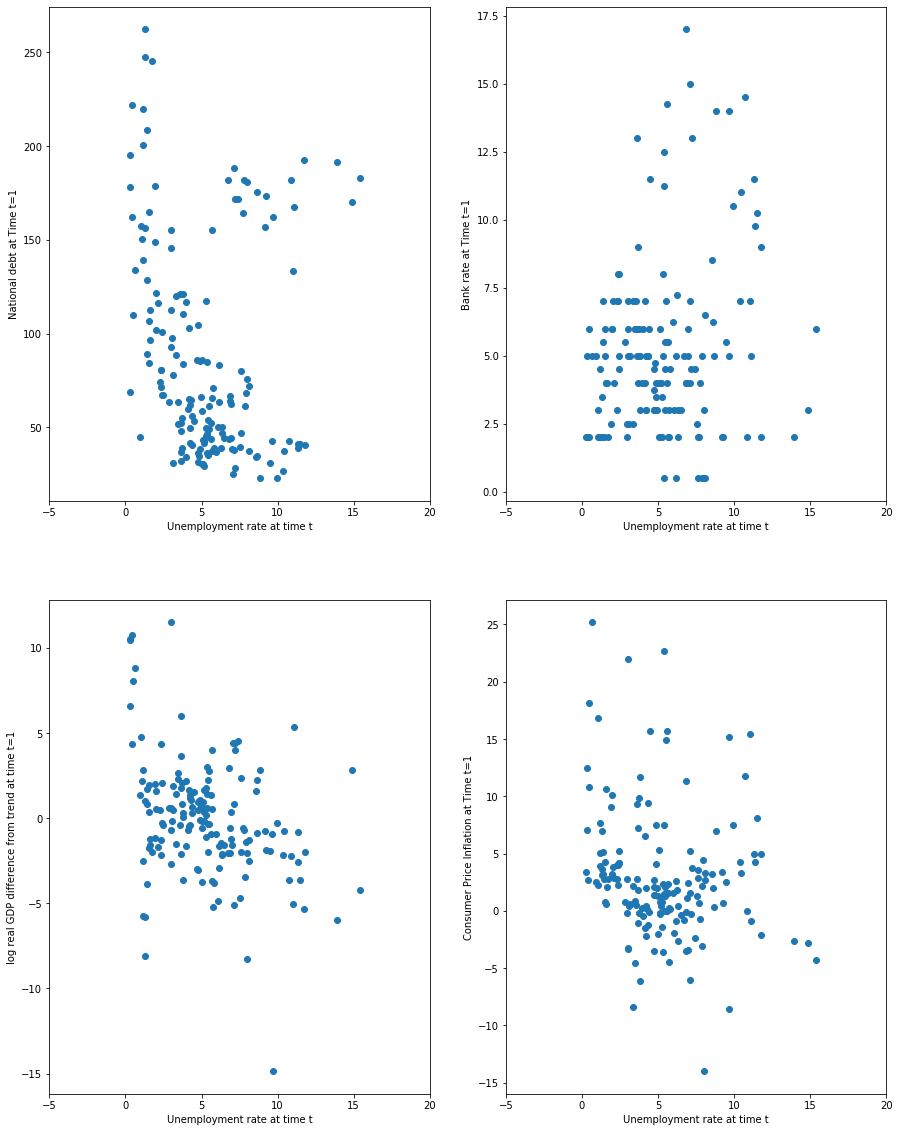

In [109]:
fig = plt.figure()

plt.figure(figsize=(15,20))

plt.subplot(2, 2, 1)
plt.xlim(-5,20)
plt.xlabel('Unemployment rate at time t')
plt.ylabel('National debt at Time t=1')
plt.scatter(unemployment, debt )

plt.subplot(2, 2, 2)
plt.xlim(-5,20)
plt.xlabel('Unemployment rate at time t')
plt.ylabel('Bank rate at Time t=1')
plt.scatter(unemployment, bank_rate )

plt.subplot(2, 2, 3)
plt.xlim(-5,20)
plt.xlabel('Unemployment rate at time t')
plt.ylabel('log real GDP difference from trend at time t=1')
plt.scatter(unemployment, GDP_trend )

plt.subplot(2, 2, 4)
plt.xlim(-5,20)
plt.xlabel('Unemployment rate at time t')
plt.ylabel('Consumer Price Inflation at Time t=1')
plt.scatter(unemployment, inflation )

In [110]:
# Make a dataframe with the intrested attribute
x = pd.concat([GDP_trend, debt, bank_rate, inflation], axis = 1)
# Define the column names
x.columns = ['GDP_trend', 'debt', 'bank_rate', 'inflation']

In [111]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 200 to 360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   GDP_trend  161 non-null    object
 1   debt       161 non-null    object
 2   bank_rate  161 non-null    object
 3   inflation  161 non-null    object
dtypes: object(4)
memory usage: 5.2+ KB


In [112]:
# Modify the tpe of the variables to float64
x['GDP_trend'] = x['GDP_trend'].astype('float64')
x['debt'] = x['debt'].astype('float64')
x['bank_rate'] = x['bank_rate'].astype('float64')
x['inflation'] = x['inflation'].astype('float64')

In [113]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 200 to 360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GDP_trend  161 non-null    float64
 1   debt       161 non-null    float64
 2   bank_rate  161 non-null    float64
 3   inflation  161 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB


In [114]:
y = unemployment
y = pd.to_numeric(y)

In [115]:
# save x and y in a separate csv files. it will be use in chapter 12.
loc = 'economic_x.csv'
x.to_csv(loc)
loc = 'economic_y.csv'
y.to_csv(loc)

In [183]:
# load data that we just saved
loc = 'economic_x.csv'
x = pd.read_csv(loc)
x = x.drop(x.columns[[0]], axis = 1)
loc = 'economic_y.csv'
y = pd.read_csv(loc, header = None)
y = y.drop(y.columns[[0]], axis = 1)
y.drop(0,axis = 0, inplace = True)
y = y.reset_index(drop=True)

In [186]:
# Scaling data
scaler_x = preprocessing.MinMaxScaler(feature_range = (0,1))
x= np.array(x).reshape((len(x),4))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range = (0,1))
y = np.array(y).reshape((len(y),1))
y = scaler_y.fit_transform(y)

x = x.tolist()
y = y.tolist()

The model will have:
- input: 10 hidden nodes with a delay of 3 time steps on the input attributes
- output: a delay of 1 time step for the output. 

In a NARX network you can also specify the incoming weight from the output, and the income weight from the input.
We set these to 10% and 80% respectively.

In [208]:
import random
random.seed(2016)

# neural network strutucture
input_nodes = 4    # we have four attributes
hidden_nodes = 10
output_nodes = 1   # we have one output predicted (unemployment)

input_order = 3    # delay of 3 time steps
output_order = 1   # delay of 1 time step

incoming_weight_from_input = 0.8
incoming_weight_from_output = 0.1

# Model using NARX
fit1= NeuralNet()
fit1.init_layers(input_nodes, [hidden_nodes], output_nodes,
                NARXRecurrent(output_order, incoming_weight_from_output,
                             input_order, incoming_weight_from_input)
                )
fit1.randomize_network()
fit1.layers[1].set_activation_type('sigmoid')
fit1.set_learnrate(0.35)
fit1.set_all_inputs(x)
fit1.set_all_targets(y)

# The train set consists of 85% of the examples, with the
# remaining observations used for the test set:
length = len(x)
learn_end_point = int(length * 0.85)
fit1.set_learn_range(0, learn_end_point)
fit1.set_test_range(learn_end_point +1, length-1)

# The learn function runs the model given the sample data
fit1.learn(epochs = 12, show_epoch_results = True, random_testing = False)

epoch: 0 MSE: 0.012487398097912241
epoch: 1 MSE: 0.006427384160242714
epoch: 2 MSE: 0.006036449439845591
epoch: 3 MSE: 0.00575579771091175
epoch: 4 MSE: 0.005546261755736912
epoch: 5 MSE: 0.005386481768594544
epoch: 6 MSE: 0.005264499679502465
epoch: 7 MSE: 0.005173259316556514
epoch: 8 MSE: 0.005108126754517866
epoch: 9 MSE: 0.0050654974466301
epoch: 10 MSE: 0.005042015921813136
epoch: 11 MSE: 0.005034170112421687


Text(0.5, 1.0, 'Mean Squared Error by Epoch')

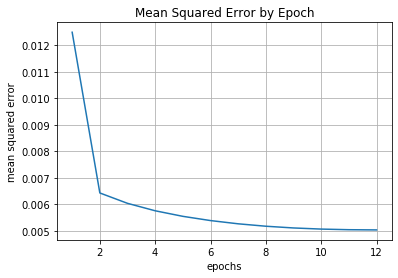

In [169]:
plt.plot(range(1, len(fit1.accum_mse) + 1, 1), fit1.accum_mse)
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.grid(True)
plt.title("Mean Squared Error by Epoch")

In [210]:
# test set performance is obtained using the test() function:
mse = fit1.test()
print( "test set MSE = ", np.round(mse, 6))

test set MSE =  0.003061


In [215]:
pred = [item[1][0] for item in fit1.test_targets_activations ]
pred1 = scaler_y.inverse_transform(np.array(pred).reshape((len(pred),1)))

actual = [item[0][0] for item in fit1.test_targets_activations ]
actual1 = scaler_y.inverse_transform(np.array(actual).reshape((len(actual),1)))

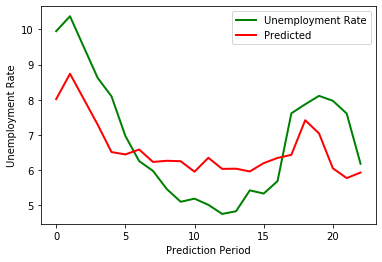

In [222]:
x_values = np.arange(23)
plt.plot(x_values, actual1, 'g-', linewidth=2, markersize=12)
plt.plot(x_values, pred1, 'r-', linewidth=2, markersize=12)

plt.xlabel('Prediction Period')
plt.ylabel('Unemployment Rate')
plt.legend(('Unemployment Rate', 'Predicted'),loc='upper right')